In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import gc
import tqdm
import copy
import gridData
import sys

import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, cluster_optics_dbscan

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import plotly as ply
from plotly import graph_objs as go
ply.io.renderers.default="notebook"

# Gaussian 2D model function, fitting, and scoring definitions

In [2]:
#gauss_params:
# zo: base height of gaussian
# h: scaling factor
# MUx, MUy: mean (center) of gaussian in x,y
# Sxx, Sxy, Syx, Syy: Covariance matrix of gaussian
#
# g2d(X) = z0 + h*exp((X-MU).T * S^-1 * (X-MU))
#
#X is a n_sample x 2 array
def gauss_2D(X,gauss_params,verbose=False):
    zo,h,mux,muy,sxx,sxy,syx,syy=gauss_params
    mu=np.array([mux,muy])
    sigInv=np.linalg.inv(np.matrix(np.array([[sxx,sxy],[syx,syy]])))
    if verbose:
        print(sigInv)
    return(
        np.array(np.apply_along_axis(
            lambda x: zo+h*np.exp(-np.abs(np.matrix(x-mu)*sigInv*np.matrix((x-mu)).T)),
            axis=1,arr=X)).flatten())
    
#takes a 2D gaussian specified by standard deviation on two principal axes
#and an angle of rotation to rotate the resulting ovoid definition in plane.
#enforces the gaussian to be concave up (bowl shape) by default
#can be changed to concave up or all either using concavity term
#concav='down' (default),'up','free'
#pax_params: [zo,h,sig_x,sig_y,theta]
#zo, h: base height and gaussian height / depth
#mux,muy: x and y coordinates of maximum height / depth respectively
#sig_x,sig_y: the standard deviation along the first and second principal axes
#theta: rotation angle in radians
def gauss_pAx_form(X,pax_params,concav='down',verbose=False):
    zo,h,mux,muy,sig_x,sig_y,theta=pax_params
    
    if concav=='down':
        H=-np.abs(h) #enforce bowl shape 
    elif concav=='up':
        H=np.abs(h) #enforce hill shape
    else:
        H=h #allow free fitting of concavity
    
    B0=np.matrix([
        [sig_x,0],
        [0,sig_y]
    ])

    tempRmat=np.matrix([
        [np.cos(theta),-np.sin(theta)],
        [np.sin(theta),np.cos(theta)]
    ])
    
    Brot=tempRmat*B0

    #normalized
    Bhat=np.matrix([
        (np.array(Brot[:,0])/np.sum(np.array(Brot[:,0])**2)).flatten(),
        (np.array(Brot[:,1])/np.sum(np.array(Brot[:,1])**2)).flatten()
    ]).T

    Amat=Bhat*np.linalg.inv(Brot)

    AmatInv=np.linalg.inv(Amat)
    
    if verbose:
        print('B0\n',B0)
        print('Brot\n',Brot)
        print('Bhat\n',Bhat)
        print('Amat\n',Amat)
        print('AmatInv\n',AmatInv)
        
    return(gauss_2D(X,np.array([zo,H,mux,muy,AmatInv[0,0],AmatInv[0,1],AmatInv[1,0],AmatInv[1,1]])))

#generates a function that takes pAx form parameterization
#and returns the root mean square deviation of the gaussian model
#over X from the corresponding values in y
#X should be an n_sample x 2 array, y should be an n_sample array
def get_gauss_pAx_score_function(X,y,giveDeltaVec=False):
    if giveDeltaVec:
        return(
            lambda pax_params: (
                np.sqrt(np.sum((y-gauss_pAx_form(X,pax_params))**2)),
                (y-gauss_pAx_form(X,pax_params))
            )
        )
    else:
        return(
            lambda pax_params: np.sqrt(np.sum((y-gauss_pAx_form(X,pax_params))**2)))

#same but for the original covariance matrix based gauss_2D model
def get_gauss_2D_score_function(X,y):
    return(
        lambda gauss_params: np.sqrt(np.sum((y-gauss_2D(X,gauss_params)**2))))

# Function to compute principal axis model parameters guess from samples

In [3]:
def get_pAx_initial_guess(X,Val,concavity='up',qcut=.05):
    if concavity=='up':
        zo=np.quantile(Val,q=1.-qcut)
        zClip=np.clip(Val,
                      np.quantile(Val,q=qcut),
                      zo)
        h=np.min(zClip)-np.max(zClip)
    elif concavity=='down':
        zo=np.quantile(Val,q=qcut)
        zClip=np.clip(Val,
                      zo,
                      np.quantile(Val,q=1.-qcut))
        h=np.max(zClip)-np.min(zClip)
    
    zDelta=np.abs(zClip-zo)
    zNorm=np.sum(zDelta)
    zFactor=zDelta/zNorm
    
    mux=np.sum(X[:,0]*zFactor)
    muy=np.sum(X[:,1]*zFactor)
    
    muVec=np.array([np.sum(X[:,ii]*zFactor) for ii in np.arange(X.shape[1])])
    
    Imat=np.matrix([
        [np.sum((X[:,iAx]-muVec[iAx])*(X[:,jAx]-muVec[jAx])*zFactor) \
         for jAx in np.arange(X.shape[1])] \
        for iAx in np.arange(X.shape[1])
    ])
    
    Ieig=np.linalg.eig(Imat)
    std_vec=np.sqrt(Ieig[0])
    
    std_mat=np.matrix(np.identity(len(std_vec))*std_vec)
    qmat=np.matrix(np.array([
        std_vec[ii]*Ieig[1][:,ii].flatten() \
        for ii in np.arange(len(std_vec))
    ]).T)
    
    Rmat=std_mat*np.linalg.inv(qmat)
    
    theta=np.mean(np.arccos(np.diag(Rmat)))
    
    mux,muy=muVec[:2]
    std_x,std_y=std_vec[:2]
    return(np.array([zo,h,mux,muy,std_x,std_y,theta]))

# Test Case

In [4]:
#Test Case
pointsx=np.linspace(-4,4,41)
pointsy=np.linspace(-4,4,41)
gridX,gridY=np.meshgrid(pointsx,pointsy)

#origin base height, unit well depth
#standard deviations of 2 units and .5 units for
#major and minor principal axes respectively
#45 degree rotation (aligns major axis to vector:[1,1])
#params:             zo,   h, mux,muy,std_x,std_y,         theta
paX_parms=np.array([2.0,-.25,-.75, -1,  2.5, 1.25,np.pi*30./180.])

gx=gridX.flatten()
gy=gridY.flatten()

gz=gauss_pAx_form(np.array([gx,gy]).T,paX_parms)

#note, the noise term will be added upon sampling.
fig = go.Figure(layout=dict(width=400,height=400,title="Test Case Gaussian Distribution"))

fig.add_trace(go.Heatmap(
        x = gx,
        y = gy,
        z = gz,
        type = 'heatmap',
        colorscale = 'Viridis'))

fig.show()

### Construct Noisy Sample
nSamples=200
noiseFactor=1/16.
noiseScale=noiseFactor*np.abs(paX_parms[1])
minX=np.min(pointsx)
maxX=np.max(pointsx)
rangeX=maxX-minX
minY=np.min(pointsy)
maxY=np.max(pointsy)
rangeY=maxY-minY
diskCenter=paX_parms[2:4]
diskRadius=1.

sampleCoords=np.random.rand(nSamples,2) * np.array([rangeX,rangeY]) + \
                np.array([minX,minY])
sampleVals=sp.interpolate.griddata(np.array([gx,gy]).T,gz,sampleCoords) + \
    np.random.normal(scale=noiseScale,size=sampleCoords.shape[0])

sampleData=pd.DataFrame({
    'X':sampleCoords[:,0],
    'Y':sampleCoords[:,1],
    'Z':sampleVals
})
sampleData=sampleData[
    np.sqrt((sampleData['X']-diskCenter[0])**2 + \
    (sampleData['Y']-diskCenter[1])**2)>=diskRadius
]

fig = go.Figure(layout=dict(title='Test Case Gaussian Distribution and Noisy Sampling'))
fig.add_trace(
    go.Scatter3d(
        x=sampleData['X'],y=sampleData['Y'],z=sampleData['Z'],
        mode='markers',
        marker=dict(size=4,color=sampleData['Z'],colorscale='Viridis')))
fig.add_trace(
    go.Surface(x=pointsx,y=pointsy,z=np.reshape(gz,newshape=gridX.shape),
               colorscale='Viridis',opacity=.75))
fig.show()


test_parms=get_pAx_initial_guess(sampleData[['X','Y']].to_numpy(),
                                 sampleData['Z'].to_numpy())

fig = go.Figure(layout=dict(title='Test Case Gaussian Distribution\nSampling, and Initial Guess'))
fig.add_trace(
    go.Scatter3d(
        x=sampleData['X'],y=sampleData['Y'],z=sampleData['Z'],
        mode='markers',
        marker=dict(size=4,color=sampleData['Z'],colorscale='Viridis'),
        hovertext=sampleData['Z']))
fig.add_trace(
    go.Surface(x=pointsx,y=pointsy,z=np.reshape(gz,newshape=gridX.shape),
               colorscale='Viridis',opacity=.75,
               colorbar=dict(x=.9,y=.5)))

### Get initial Guess
gtest=gauss_pAx_form(np.array([gx,gy]).T,test_parms)

fig.add_trace(
    go.Surface(x=pointsx,y=pointsy,z=np.reshape(gtest,newshape=gridX.shape),
               #colorscale='Viridis',
               opacity=.5))
fig.show()

### Optimize parameters
scoreFun=get_gauss_pAx_score_function(sampleData[['X','Y']].to_numpy(),sampleData['Z'].to_numpy())

maxIters=1000
with tqdm.tqdm_notebook(maxIters) as pbar:
    
    def update_pbar(xk):
        pbar.set_description_str(','.join(list(map(lambda x:'%.1e'%x,xk))))
        pbar.update()
    
    optParmsFit=sp.optimize.minimize(
        scoreFun,
        test_parms,
        callback=update_pbar,
        options={'maxiter':maxIters})
print(optParmsFit)

print('actual gauss parms:',paX_parms)
print('optimized model parms:',optParmsFit.x)

fig2 = go.Figure(layout=dict(title="Test Case Gaussian Distribution Sampling, and Fitted Model"))
fig2.add_trace(
    go.Scatter3d(
        x=sampleData['X'],y=sampleData['Y'],z=sampleData['Z'],
        mode='markers',
        marker=dict(size=4,color=sampleData['Z'],colorscale='Viridis')
    ))
fig2.add_trace(
    go.Surface(x=pointsx,y=pointsy,z=np.reshape(gz,newshape=gridX.shape),
               colorscale='Viridis',opacity=.75,
               colorbar=dict(x=.9,y=.5)))

optz=gauss_pAx_form(np.array([gx,gy]).T,optParmsFit.x)

fig2.add_trace(
    go.Surface(x=pointsx,y=pointsy,z=np.reshape(optz,newshape=gridX.shape),
               #colorscale='Viridis',
               opacity=.5))

fig2.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




      fun: 0.2033248521243369
 hess_inv: array([[ 2.37547355e-03,  1.81220803e-03,  1.78066832e-03,
         2.24902164e-03,  5.19237209e-02,  2.76955092e-02,
        -1.01087269e-03],
       [ 1.81220803e-03,  6.49306557e-02,  2.23985674e-02,
         3.70436160e-02,  3.53491983e-01,  1.64526932e-01,
        -5.61647736e-02],
       [ 1.78066832e-03,  2.23985674e-02,  1.14301514e+00,
         6.44363438e-01,  1.94737006e-01, -6.73778099e-02,
        -5.95851357e-02],
       [ 2.24902164e-03,  3.70436160e-02,  6.44363438e-01,
         9.12244785e-01,  1.68720747e-01,  1.28126516e-02,
        -2.13511783e-01],
       [ 5.19237209e-02,  3.53491983e-01,  1.94737006e-01,
         1.68720747e-01,  5.07210203e+00,  9.24954087e-01,
        -1.53757925e-01],
       [ 2.76955092e-02,  1.64526932e-01, -6.73778099e-02,
         1.28126516e-02,  9.24954087e-01,  1.19586415e+00,
        -8.04508579e-02],
       [-1.01087269e-03, -5.61647736e-02, -5.95851357e-02,
        -2.13511783e-01, -1.5375792

# Load Headgroup Data

We have headgroup data saved every 120 ps. Since membrane curvature is expected to change relatively slowly, we can use a stride of 10 frames to save space and computation time.

In [5]:
dataDir='headgroupDataDir'
searchPattern='phosphorous_COM_data.csv'
omitPattern='swp'

dataFileNameList=[filename for filename in os.listdir(dataDir) \
                  if (searchPattern in filename) and \
                     not (omitPattern in filename)]

def readTable(filepath,callback=None):
    if not (callback is None):
        callback(filepath)
    tableDat=pd.read_csv(filepath)
    tableDat.drop(columns=[colName for colName in tableDat.columns \
                           if 'Unnamed' in colName])
    return(tableDat)


with tqdm.tqdm_notebook(dataFileNameList) as pbar:
    def updatePbar(filepath):
        pbar.set_description_str(filepath.split('/')[1])
    headgroupData=pd.concat([
        readTable('/'.join([dataDir,filename]),callback=updatePbar) \
        for filename in pbar])

#Curvature is slow to change so only need every tenth frame
headgroupData=headgroupData[(headgroupData.Frame%10)==0]
headgroupData.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Unnamed: 0 System  Frame Resname  Resnum           X           Y          Z
0           0   cut1      0    POPC       0  136.211548  214.106812  80.133385
1           0   cut1      0    POPC       1   19.501858  171.373123  81.155701
2           0   cut1      0    POPC       2  137.054169   21.917259  91.922020
3           0   cut1      0    POPC       3  107.586929  170.271927  74.992020
4           0   cut1      0    POPC       4  151.169907  172.822510  86.682381

In [6]:
#remove Unnamed column
headgroupData=headgroupData[headgroupData.columns[1:]]
headgroupData.head()

System  Frame Resname  Resnum           X           Y          Z
0   cut1      0    POPC       0  136.211548  214.106812  80.133385
1   cut1      0    POPC       1   19.501858  171.373123  81.155701
2   cut1      0    POPC       2  137.054169   21.917259  91.922020
3   cut1      0    POPC       3  107.586929  170.271927  74.992020
4   cut1      0    POPC       4  151.169907  172.822510  86.682381

In [8]:
for group in tqdm.tqdm_notebook(headgroupData.groupby(['System']),desc='saving headgroup data'):
    groupName,groupData=group
    groupData.to_csv('headgroup_data_table.{sysname}.csv'.format(sysname=groupName),
                     index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



# Load Joint Data

If the loading section above is already done, than you can just start here.

In [9]:
headgroupFilenames=[filename for filename in os.listdir() \
                    if ('headgroup_data_table' in filename) and (len(filename.split('.'))==3)]
headgroupDataTables=[]
for filename in tqdm.tqdm_notebook(headgroupFilenames,desc='loading headgroup data'):
    headgroupDataTables.append(pd.read_csv(filename))
headgroupData=pd.concat(headgroupDataTables)
headgroupDataTables=[]
gc.collect()
headgroupData.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



System  Frame Resname  Resnum           X           Y          Z
0   cut1      0    POPC       0  136.211548  214.106812  80.133385
1   cut1      0    POPC       1   19.501858  171.373123  81.155701
2   cut1      0    POPC       2  137.054169   21.917259  91.922020
3   cut1      0    POPC       3  107.586929  170.271927  74.992020
4   cut1      0    POPC       4  151.169907  172.822510  86.682381

# Test model fitting on single frame

## Select and visualize data

In [10]:
#Lets try out the fitting procedure on a test frame
testSet=headgroupData.query(
    '(System == "cut2") and (Frame == 1000)')

testSet.head()

sampleData=testSet[['X','Y','Z']]

fig = go.Figure(layout=dict(title='Headgroup Scatter Plot 3D'))
fig.add_trace(
    go.Scatter3d(
        x=sampleData['X'],y=sampleData['Y'],z=sampleData['Z'],
        mode='markers',
        marker=dict(size=4,color=sampleData['Z'],colorscale='Viridis')))
fig.show()

## Determine leaflet residues

As can be seen above, the headgroup data contains lipids from both leaflets. This gaussian model is only built to handle one leaflet at a time, so we need to determine which residues belong to which leaflet.

For simple flat membranes this is easily accomplished by simply selecting an appropriate Z coordinate cutoff. E.g. headgroups above the mean Z value are in the upper leaflet and those below are in the lower leaflet.

Unfortunately, this membrane is curved (which is why we are using a gaussian model to begin with). So a simple cutoff technique could put residues into the wrong leaflets.

Fortunately, in this first frame, even though the membrane has some curve, which may prevent a simple cutoff, the lipids in the upper leaflet are all closer to each other than they are to any lipid in the lower leaflet, and vice-versa.

This means we can try clustering. Further, since the lipids should not be able to change leaflets from one frame to the next, we only need to do this for one frame from each system!

This selection process should be down by hand for each system. It is important to make sure that:
    
    * exactly 2 clusters are being found
    * all lipids get placed into one of those 2 clusters
    * lipids in one leaflet are not getting put into the other leaflet
    
Below illustrates using the 'OPTICS' clustering algorithm from scikit learn. It is a close cousin to dbscan and hdbscan. If there are problems, adjusting min_cluster_size may help. If that still fails there are other options that can be adjusted as well. 

In [11]:
testSet=headgroupData.query(
    '(System == "cut2") and (Frame == 10)').copy()
clusterer=OPTICS(metric='euclidean',
                 min_cluster_size=int(testSet.shape[0]/2.1),
                 max_eps=(testSet.Z.max()-testSet.Z.min())/2.)
#clusterer=skl.cluster.KMeans(n_clusters=6)
labels=clusterer.fit_predict(testSet[['X','Y','Z']].to_numpy())
testSet['Cluster']=labels

if (testSet.Cluster<0).any():
    print('Merging outlier headgroups into clusters with nearest headgroup')
    outliers=testSet[testSet.Cluster<0].copy()
    mainClusters=testSet[testSet.Cluster>=0]
    display(outliers)
    outliers['Cluster']=outliers[['X','Y','Z']].apply(
        lambda x: mainClusters['Cluster'].loc[mainClusters[['X','Y','Z']].apply(
            lambda y: ((y-x)**2).sum(),
            axis=1
        ).idxmin()],
        axis=1
    )
    testSet['Cluster'].loc[outliers.index]=outliers['Cluster']

fig = go.Figure(layout=dict(title='Headgroup Scatter Plot 3D'))
fig.add_trace(
    go.Scatter3d(
        x=testSet['X'],y=testSet['Y'],z=testSet['Z'],
        mode='markers',
        marker=dict(
            size=4,
            color=testSet['Cluster']),
        hovertext=testSet['Cluster'].map(lambda x:'cluster %g'%x)))
fig.show()

leafletMapper=pd.DataFrame({
    'System':testSet['System'].to_numpy(),
    'Resnum':testSet['Resnum'].to_numpy(),
    'Leaflet':labels})
leafletMapper=leafletMapper.set_index(['System','Resnum'])
leafletMapper.head()

Merging outlier headgroups into clusters with nearest headgroup


System  Frame Resname  Resnum           X           Y          Z  Cluster
1255   cut2     10    POPC      73  199.313705  134.082916  81.591301       -1
1356   cut2     10    POPC     174  201.255859  136.578796  89.933189       -1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Leaflet
System Resnum         
cut2   0             0
       1             0
       2             0
       3             0
       4             0

## Generate Leaflet mapping for each system

In [12]:
#This will use the clustering above to assign each residue to a leaflet
#since the clustering method can also yield an 'unassigned' cluster,
#we will need to map that to one of the 2 leaflets.
#The plot is colored by original cluster label. For unassigned clusters,
#the hovertext will tell you what cluster it got reasigned to.
#Be sure to look at the visualization!
leafletDeterminationSet=headgroupData.query('Frame == 10')
leafletMappingFrames=[]
for systemGroup in leafletDeterminationSet.groupby('System'):
    groupName,groupData=systemGroup
    clusterer=OPTICS(metric='euclidean',min_cluster_size=int(groupData.shape[0]/2.15))
    labels=clusterer.fit_predict(groupData[['X','Y','Z']].to_numpy())
    
    testSet=groupData.copy()
    
    testSet['Cluster']=labels

    if (testSet.Cluster<0).any():
        print('Merging {:s} outlier headgroups into clusters with nearest headgroup'.format(
            groupName))
        outliers=testSet[testSet.Cluster<0].copy()
        mainClusters=testSet[testSet.Cluster>=0]
        display(outliers)
        outliers['Cluster']=outliers[['X','Y','Z']].copy().apply(
            lambda x: mainClusters['Cluster'].loc[mainClusters[['X','Y','Z']].apply(
                lambda y: ((y-x)**2).sum(),
                axis=1
            ).idxmin()],
            axis=1
        )
        testSet['Cluster'].loc[outliers.index]=outliers['Cluster']
    
    leafletMappingFrames.append(testSet[['System','Resnum','Cluster']].copy())
    fig = go.Figure(layout=dict(title='{:s} Headgroup Clustering'.format(groupName)))
    fig.add_trace(
        go.Scatter3d(
            x=testSet['X'],y=testSet['Y'],z=testSet['Z'],
            mode='markers',
            marker=dict(
                size=4,
                color=labels),
            hovertext=testSet['Cluster'].map(lambda x: 'cluster %g'%x)
        ))
    fig.show()
    
leafletMapper=pd.concat(leafletMappingFrames).set_index(['System','Resnum'])
leafletMapper.to_csv('Leaflet_Mapper_Table.csv')
leafletMapper.head()

Merging cut2 outlier headgroups into clusters with nearest headgroup


System  Frame Resname  Resnum           X           Y          Z  Cluster
1255   cut2     10    POPC      73  199.313705  134.082916  81.591301       -1
1356   cut2     10    POPC     174  201.255859  136.578796  89.933189       -1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Cluster
System Resnum         
cut1   0             0
       1             0
       2             0
       3             0
       4             0

## Apply leaflet mapping to headgroup data

In [13]:
leafletMapper=pd.read_csv('Leaflet_Mapper_Table.csv').set_index(['System','Resnum'])
leafletMapper.head()

Cluster
System Resnum         
cut1   0             0
       1             0
       2             0
       3             0
       4             0

In [14]:
tqdm.tqdm_pandas(tqdm.tqdm)
headgroupData['Leaflet']=headgroupData[['System','Resnum']].progress_apply(
    lambda x: leafletMapper['Cluster'].loc[
        tuple(x[['System','Resnum']])],
    axis=1)
headgroupData.head()


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

100%|██████████| 2414880/2414880 [18:56<00:00, 2125.69it/s]


System  Frame Resname  Resnum           X           Y          Z  Leaflet
0   cut1      0    POPC       0  136.211548  214.106812  80.133385        0
1   cut1      0    POPC       1   19.501858  171.373123  81.155701        0
2   cut1      0    POPC       2  137.054169   21.917259  91.922020        0
3   cut1      0    POPC       3  107.586929  170.271927  74.992020        0
4   cut1      0    POPC       4  151.169907  172.822510  86.682381        0

In [15]:
for group in tqdm.tqdm_notebook(headgroupData.groupby(['System','Leaflet']),
                                desc='Saving leaflet labled headgroup data'):
    groupName,groupData=group
    groupData.to_csv('headgroup_data_with_leaflet_labels.{sysname}.leaflet_{leafnum}.csv'.format(
            sysname=groupName[0],leafnum=groupName[1]),
                     index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



# Test fitting on one frame from headgroup data

In [16]:
filenames=[filename for filename in os.listdir() \
           if ('headgroup_data_with_leaflet_labels') in filename and \
              (len(filename.split('.'))==4)]
headgroupTables=[]
for filename in tqdm.tqdm_notebook(filenames,desc='Loading leaflet labeled headgroup data'):
    headgroupTables.append(pd.read_csv(filename))
headgroupData=pd.concat(headgroupTables)
headgroupTables=[]
gc.collect()
headgroupData.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



System  Frame Resname  Resnum           X           Y          Z  Leaflet
0   cut1      0    POPC       0  136.211548  214.106812  80.133385        0
1   cut1      0    POPC       1   19.501858  171.373123  81.155701        0
2   cut1      0    POPC       2  137.054169   21.917259  91.922020        0
3   cut1      0    POPC       3  107.586929  170.271927  74.992020        0
4   cut1      0    POPC       4  151.169907  172.822510  86.682381        0

In [17]:
#Try fitting one test frame from the lealfet labeled headgroup data
#create a 3D rendering using plotly to see how well the model matches the data
frame=0
sysName="cut1"
leaflet=0
testSet=headgroupData.query(
    '(System == "{sysname}") and (Leaflet == {leaflet}) and (Frame == {frame})'.format(
        sysname=sysName,leaflet=leaflet,frame=frame)
)
display(testSet.shape,testSet.head())

maxIters=1000
with tqdm.tqdm_notebook(maxIters) as pbar:
    def update_pbar(xk):
        pbar.set_description_str(','.join(list(map(lambda x:'%.1e'%x,xk))))
        pbar.update()
        
    testParmFit=sp.optimize.minimize(
        get_gauss_pAx_score_function(testSet[['X','Y']].to_numpy(),testSet['Z'].to_numpy()),
        get_pAx_initial_guess(testSet[['X','Y']].to_numpy(),testSet['Z'].to_numpy()),
        callback=update_pbar,
        method='BFGS',
        options={'maxiter':maxIters})

print('---Fitting Results---')
display(testParmFit)

testSetOptParms=testParmFit.x

pointsx=np.arange(testSet.X.min(),testSet.X.max()+1)
pointsy=np.arange(testSet.Y.min(),testSet.Y.max()+1)

gridX,gridY=np.meshgrid(pointsx,pointsy)
gx=gridX.flatten()
gy=gridY.flatten()

gTestOpt=gauss_pAx_form(np.array([gx,gy]).T,testSetOptParms)

fig = go.Figure(layout=dict(
    title='{sysname} Leaflet {leaflet} Frame {frame} Headgroup Test Results'.format(
        sysname=sysName,leaflet=leaflet,frame=frame)))
fig.add_trace(
    go.Scatter3d(
        x=testSet['X'],y=testSet['Y'],z=testSet['Z'],
        mode='markers',
        marker=dict(size=4,color=testSet['Z'],colorscale='Viridis'),
        hovertext=testSet['Resnum'].map(lambda x: 'Resnum: %g'%x)))
fig.add_trace(
    go.Surface(x=pointsx,y=pointsy,z=np.reshape(gTestOpt,newshape=gridX.shape),
               colorscale='Viridis',opacity=.75,
               colorbar=dict(x=.9,y=.5)))
fig.show()

(607, 8)

System  Frame Resname  Resnum           X           Y          Z  Leaflet
0   cut1      0    POPC       0  136.211548  214.106812  80.133385        0
1   cut1      0    POPC       1   19.501858  171.373123  81.155701        0
2   cut1      0    POPC       2  137.054169   21.917259  91.922020        0
3   cut1      0    POPC       3  107.586929  170.271927  74.992020        0
4   cut1      0    POPC       4  151.169907  172.822510  86.682381        0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




---Fitting Results---


      fun: 99.80478811788387
 hess_inv: array([[ 2.60055339e+00, -1.80233416e+00,  6.52053713e-01,
        -7.16957894e-01,  1.49444847e+01,  1.24874933e+01,
         6.19140453e-02],
       [-1.80233416e+00,  2.81610858e+00, -1.02790353e+00,
         6.66621758e-01, -7.22334303e+00, -3.61658558e+00,
         8.34435952e-03],
       [ 6.52053713e-01, -1.02790353e+00,  2.16765730e+01,
        -1.64300387e+00,  6.76059084e+00, -1.24929708e+01,
        -1.27375726e-01],
       [-7.16957894e-01,  6.66621758e-01, -1.64300387e+00,
         1.03881506e+01, -3.98826824e+00, -6.34443129e-01,
         1.36349054e-02],
       [ 1.49444847e+01, -7.22334303e+00,  6.76059084e+00,
        -3.98826824e+00,  1.12309671e+02,  7.04798000e+01,
         6.49005618e-01],
       [ 1.24874933e+01, -3.61658558e+00, -1.24929708e+01,
        -6.34443129e-01,  7.04798000e+01,  1.24514659e+02,
         8.08736826e-01],
       [ 6.19140453e-02,  8.34435952e-03, -1.27375726e-01,
         1.36349054e-02,  6.49005618e

# Serial Version of fitting
#This procedure will take a long time in serial (upwards of 30 hours). 
#A python equivalent (fit_gauss_2D_subset.py) is provided that will allow you to
#load and compute a subset of the data for a given leaflet and system. This can be wrapped in an appropriate
#script to run in parallel using your parallelization / job scheduler of choice.
#for linux / openbsd users, the gnuparallel package is a good choice.
#alternatively, one could also make use of python's parallelization methods as well.
#given that each individual frame is done independently this is a clear and relatively
#straightforward case of an 'embarassingly parallel' task

maxIters=1000
fitData=[]
with tqdm.tqdm_notebook(headgroupData.groupby(['System','Frame','Leaflet'])) as groupPbar:
    with tqdm.tqdm_notebook() as fitPbar:
        for testGroup in groupPbar:
            testName,testSet=testGroup
            groupPbar.set_description_str(str(testName))
            sysName,frame,leaflet=testName

            def update_pbar(xk):
                fitPbar.set_description_str(','.join(list(map(lambda x:'%.1e'%x,xk))))
                fitPbar.update()

            testParmFit=sp.optimize.minimize(
                get_gauss_pAx_score_function(testSet[['X','Y']].to_numpy(),testSet['Z'].to_numpy()),
                get_pAx_initial_guess(testSet[['X','Y']].to_numpy(),testSet['Z'].to_numpy()),
                callback=update_pbar,
                method='BFGS',
                options={'maxiter':maxIters})

            fitEntry=[sysName,frame,leaflet]
            for val in testParmFit.x:
                fitEntry.append(val)

            fitData.append(copy.deepcopy(fitEntry))

            fitPbar.n=0
            fitPbar.refresh()

#[zo,h,sig_x,sig_y,theta]
fitData=np.array(fitData)
fitFrame=pd.DataFrame({
    'System':fitData[:,0],
    'Frame':fitData[:,1],
    'Leaflet':fitData[:,2],
    'zo':fitData[:,3],
    'h':fitData[:,4],
    'mux':fitData[:,5],
    'muy':fitData[:,6],
    'std_p1':fitData[:,7],
    'std_p2':fitData[:,8],
    'theta':fitData[:,9]
})
fitFrame.head()
display(fitFrame.head())
for group in tqdm.tqdm_notebook(fitData.groupby(['System','Leaflet'])):
    groupName,groupData=group
    groupData.to_csv('Gauss_2D_Fit_Data.{sysname}.leaflet_{leafnum}.csv'.format(
            sysname=groupName[0],leafnum=groupName[1]),index=False)

In [18]:
filenames=[filename for filename in os.listdir() \
           if ('headgroup_data_with_leaflet_labels') in filename and \
              (len(filename.split('.'))==4)]
headgroupTables=[]
for filename in tqdm.tqdm_notebook(filenames,desc='Loading leaflet labeled headgroup data'):
    headgroupTables.append(pd.read_csv(filename))
headgroupData=pd.concat(headgroupTables)
headgroupTables=[]
gc.collect()
headgroupData.head()
headgroupData=pd.read_csv('headgroup_data_with_leaflet_labels.csv')
display(headgroupData.head())

filterPattern1='Gauss_2D_Fit_Data'
filterPattern2='csv'
filterPattern3='leaflet'

dataFiles=[filename for filename in os.listdir() \
           if (filterPattern1 in filename) and \
            (filterPattern2 in filename) and \
            (filterPattern3 in filename)]

fitDataFrames=[]
for dataFile in tqdm.tqdm_notebook(dataFiles):
    fitDataFrames.append(pd.read_csv(dataFile))

fitData=pd.concat(fitDataFrames)
fitDataFrames=[]
gc.collect()
fitData.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



System  Frame Resname  Resnum           X           Y           Z  Leaflet
0   cut2   6590    POPC       0  188.954803   81.842751  100.636909        0
1   cut2   6590    POPC       1   39.782215   15.844467   94.820236        0
2   cut2   6590    POPC       2  158.317169   31.741585  103.553604        0
3   cut2   6590    POPC       3  128.730148  134.877518   85.101051        0
4   cut2   6590    POPC       4   18.235004  213.724365   88.795479        0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



System  Frame  Leaflet         zo          h        mux         muy  \
0   cut1      0        0  95.706489 -19.798849  82.842708  144.717966   
1   cut1     10        0  95.015343 -19.327395  86.066674  149.664920   
2   cut1     20        0  98.117849 -22.647328  86.633661  155.355605   
3   cut1     30        0  96.666027 -21.133921  85.974086  155.559486   
4   cut1     40        0  98.980492 -22.311634  84.460378  151.802050   

       std_p1     std_p2     theta  
0   86.524886  96.774724  4.402836  
1   88.234589  85.925738  5.900989  
2  101.467637  94.620260 -0.272412  
3  102.136036  93.308087  9.305616  
4  100.356577  90.213476  1.586451

# Calculate principal curvatures

Now that we have the fitting for each system, leaflet, and frame,
we need to use this information to calculate the curvature of the gaussian model
at its apex.

Our model contains std_p1 and std_p2 which are the standard deviations along the two
principal axes of our gaussian (in no particular order). This is precisely what is needed
to compute the principal curvatures, e.g. the curvature along each of the principal axes.

For a simple planar curve, we may define the signed curvature as:
$$k=\frac{y''}{(1+y'^2)^{4/3}}$$

Our model will correspond to such planar gaussians along its two principal axes. So now we will
make use of the second derivative of a gaussian given as $h*exp(x^2/\sigma ^2)$:
$$\frac{d^2}{dx^2}(h * exp(-x^2/σ^2)) = (h * (4 x^2 - 2 σ^2) *exp(-x^2/σ^2) )/σ^4$$

Fortunately, at the apex (a local extremum) we know that the first derivative of our gaussian will be zero
(by the fact that we are at a local extremum) and also, by definition of our model, x (or technically the mu-x term inside the exponential) will be zero as well. Thus, at x=0, we get:
$$k=\frac{d^2}{dx^2}(h * exp(-x^2/σ^2))|_{x=0} = (-2 \sigma^2 h )/(\sigma^4) = -2\frac{h}{\sigma^2}$$

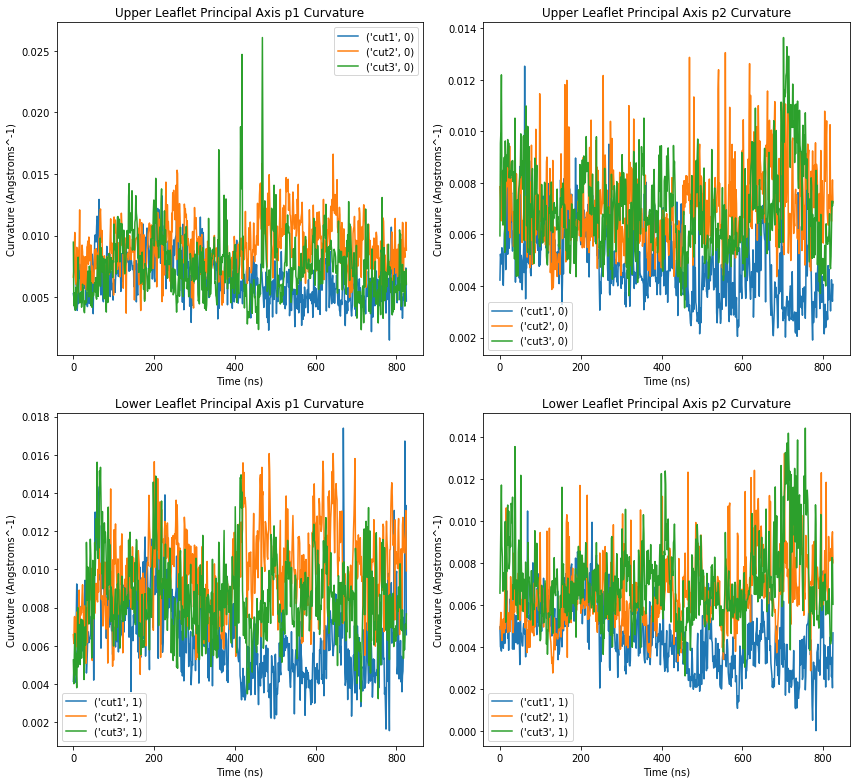

In [22]:
paxCols=[colname for colname in fitData.columns \
         if 'std_p' in colname]

for paxCol in paxCols:
    axname=paxCol.split('_')[1]
    fitData['k_{:s}'.format(axname)]=fitData[['h',paxCol]].apply(
        lambda x: -2*x['h']/x[paxCol]**2,
        axis=1)
    
nLeaflets=fitData.Leaflet.max()-fitData.Leaflet.min()+1
kCols=[colname for colname in fitData.columns \
       if 'k_p' in colname]
nKcols=len(kCols)
fig,axs=plt.subplots(nLeaflets,nKcols)
fig.set_figwidth(12)
fig.set_figheight(11)
for plotGroup in fitData.groupby(['System','Leaflet']):
    plotName,plotFrame=plotGroup
    for ikCol,kCol in enumerate(kCols):
        axr=plotName[1]
        axc=ikCol
        ax=axs[axr][axc]
        sns.lineplot(
            plotFrame.Frame.to_numpy()*.12,
            plotFrame[kCol].to_numpy(),
            label=plotName,
            ax=ax
        )
        ax.set_title('{leafname:s} Leaflet Principal Axis {paxname:s} Curvature'.format(
            paxname=kCol.split('_')[1],
            leafname=['Upper','Lower'][plotName[1]]))
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Curvature (Angstroms^-1)')
plt.tight_layout()
plt.show()

# Gaussian and Mean Curvature

Now that we have the curvature in each principal axis, we compute the mean and gaussian curvatures,
where mean curvature is the mean of the two principal curvatures and gaussian curvature is the product
of the two curvatures.

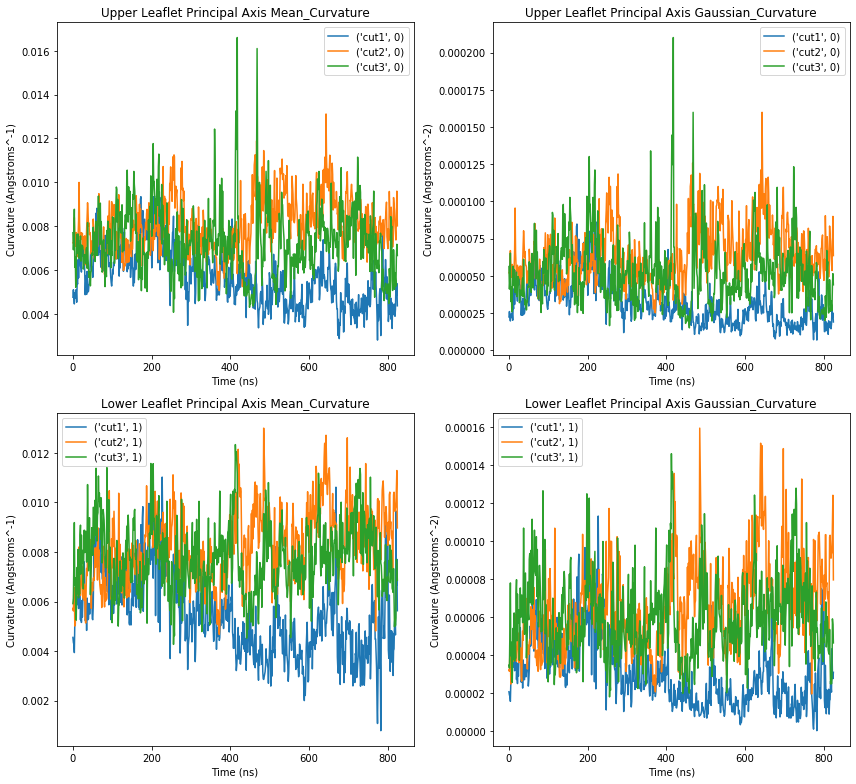

In [23]:
kCols=[colname for colname in fitData.columns \
       if 'k_p' in colname]
fitData['Mean_Curvature']=fitData[kCols].apply(
    lambda x: (np.max(x)+np.min(x))/2,axis=1)
fitData['Gaussian_Curvature']=fitData[kCols].apply(
    lambda x: (np.max(x)*np.min(x)),axis=1)

kCols=['Mean_Curvature','Gaussian_Curvature']

nLeaflets=fitData.Leaflet.max()-fitData.Leaflet.min()+1
#kCols=[colname for colname in fitData.columns \
#       if 'k_p' in colname]
nKcols=len(kCols)
fig,axs=plt.subplots(nLeaflets,nKcols)
fig.set_figwidth(12)
fig.set_figheight(11)
for plotGroup in fitData.groupby(['System','Leaflet']):
    plotName,plotFrame=plotGroup
    for ikCol,kCol in enumerate(kCols):
        axr=plotName[1]
        axc=ikCol
        ax=axs[axr][axc]
        sns.lineplot(
            plotFrame.Frame.to_numpy()*.12,
            plotFrame[kCol].to_numpy(),
            label=plotName,
            ax=ax
        )
        ax.set_title('{leafname:s} Leaflet Principal Axis {paxname:s}'.format(
            paxname=kCol,
            leafname=['Upper','Lower'][plotName[1]]))
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Curvature ({:s})'.format(
            'Angstroms^-1' if 'Mean' in kCol else 'Angstroms^-2'))
plt.tight_layout()
plt.show()

In [24]:
fitData['K_X_projection']=fitData[['k_p1','k_p2','theta']].apply(
    lambda x: x['k_p1']*np.cos(x['theta']+x['k_p2']*np.sin(x['theta'])),
    axis=1).abs()
fitData['K_Y_projection']=fitData[['k_p1','k_p2','theta']].apply(
    lambda x: -x['k_p1']*np.sin(x['theta']+x['k_p2']*np.cos(x['theta'])),
    axis=1).abs()
fitData.head()

System  Frame  Leaflet         zo          h        mux         muy  \
0   cut1      0        0  95.706489 -19.798849  82.842708  144.717966   
1   cut1     10        0  95.015343 -19.327395  86.066674  149.664920   
2   cut1     20        0  98.117849 -22.647328  86.633661  155.355605   
3   cut1     30        0  96.666027 -21.133921  85.974086  155.559486   
4   cut1     40        0  98.980492 -22.311634  84.460378  151.802050   

       std_p1     std_p2     theta      k_p1      k_p2  Mean_Curvature  \
0   86.524886  96.774724  4.402836  0.005289  0.004228        0.004759   
1   88.234589  85.925738  5.900989  0.004965  0.005235        0.005100   
2  101.467637  94.620260 -0.272412  0.004399  0.005059        0.004729   
3  102.136036  93.308087  9.305616  0.004052  0.004855        0.004453   
4  100.356577  90.213476  1.586451  0.004431  0.005483        0.004957   

   Gaussian_Curvature  K_X_projection  K_Y_projection  
0            0.000022        0.001632        0.005036  
1            0.000026        0.004603        0.001829  
2            0.000022        0.004236        0.001163  
3            0.000020        0.004023        0.000501  
4            0.000024        0.000094        0.004430

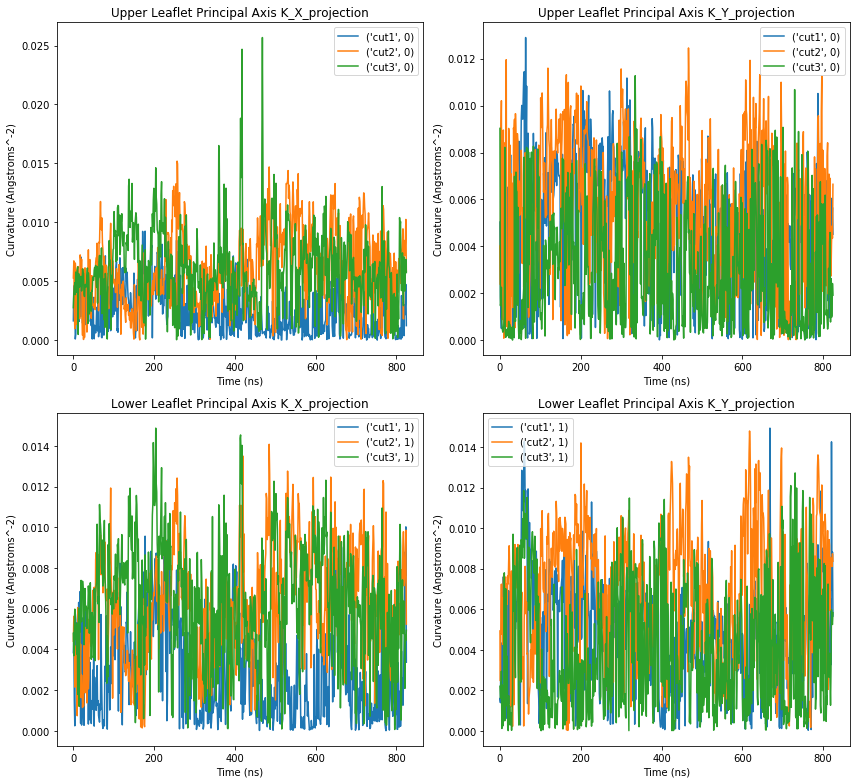

In [25]:
kCols=['K_X_projection','K_Y_projection']

nLeaflets=fitData.Leaflet.max()-fitData.Leaflet.min()+1
#kCols=[colname for colname in fitData.columns \
#       if 'k_p' in colname]
nKcols=len(kCols)
fig,axs=plt.subplots(nLeaflets,nKcols)
fig.set_figwidth(12)
fig.set_figheight(11)
for plotGroup in fitData.groupby(['System','Leaflet']):
    plotName,plotFrame=plotGroup
    for ikCol,kCol in enumerate(kCols):
        axr=plotName[1]
        axc=ikCol
        ax=axs[axr][axc]
        sns.lineplot(
            plotFrame.Frame.to_numpy()*.12,
            plotFrame[kCol].to_numpy(),
            label=plotName,
            ax=ax
        )
        ax.set_title('{leafname:s} Leaflet Principal Axis {paxname:s}'.format(
            paxname=kCol,
            leafname=['Upper','Lower'][plotName[1]]))
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('Curvature ({:s})'.format(
            'Angstroms^-1' if 'Mean' in kCol else 'Angstroms^-2'))
plt.tight_layout()
plt.show()

In [26]:
fitData.to_csv('Gaussian_2D_fit_data_with_curvatures.csv',index=None)

## Visualize fitted model

Visualize the 2D gaussian model for each leaflet along with the headgroup data for selected systems and frames.

By default, the gridsize used to render the gaussian model will be 2 angstroms, to allow for faster rendering.

In [44]:
#Functions to render a given set of headgroup data and model parameters
def render_model_frame(pointDataSet,modelParameters,
                       gridData=None,cMinMax=None,gridsize=2.0,plotFig=None,
                       showFig=False,giveFig=False):
    if gridData is None:
        grid_data=build_grid(pointDataSet,gridsize=gridsize)
    else:
        grid_data=gridData
        
    if cMinMax is None:
        cMin=pointDataSet.Z.min()
        cMax=pointDataSet.Z.max()
    else:
        cMin,cMax=cMinMax
    pointsx,pointsy,gridX,gridY,gx,gy=[grid_data[dataName] for dataName in \
                                   ['pointsx','pointsy','gridX','gridY','gx','gy']]
    
    gTestOpt=gauss_pAx_form(np.array([gx,gy]).T,modelParameters)

    if plotFig is None:
        fig = go.Figure()
    else:
        fig = plotFig
    fig.add_trace(
        go.Scatter3d(
            x=pointDataSet['X'],y=pointDataSet['Y'],z=pointDataSet['Z'],
            mode='markers',
            marker=dict(
                size=4,color=pointDataSet['Z'],
                cmin=cMin,cmax=cMax,
                colorscale='Viridis'),
            hovertext=pointDataSet['Resnum'].map(lambda x: 'Resnum: %g'%x)))
    fig.add_trace(
        go.Surface(x=pointsx,y=pointsy,z=np.reshape(gTestOpt,newshape=gridX.shape),
                   colorscale='Viridis',opacity=.75,
                   cmin=cMin,cmax=cMax,
                   colorbar=dict(x=.9,y=.5)))
    if showFig:
        fig.show()
    if giveFig:
        return(fig)
    
def build_grid(pointData,gridsize=2.0):
    pointsx=np.arange(headgroupData.X.min()-gridsize/2,headgroupData.X.max()+gridsize/2,gridsize)
    pointsy=np.arange(headgroupData.Y.min()-gridsize/2,headgroupData.Y.max()+gridsize/2,gridsize)

    gridX,gridY=np.meshgrid(pointsx,pointsy)

    gx=gridX.flatten()
    gy=gridY.flatten()
    return({
        'pointsx':pointsx,
        'pointsy':pointsy,
        'gridX':gridX,
        'gridY':gridY,
        'gx':gx,
        'gy':gy
    })

In [45]:
#Test rendering functions
testQuery='(System == "cut1") and (Frame == 10)'
testPoints=headgroupData.query(testQuery)
cMinMax=[testPoints.Z.min(),testPoints.Z.max()]

testQuery='(System == "cut1") and (Frame == 10) and (Leaflet == 0)'
testPointData=headgroupData.query(testQuery)
display(testPointData.head())
testFitData=fitData.query(testQuery)
display(testFitData)

grid_data=build_grid(testPointData)
modelParameters=testFitData[['zo','h','mux','muy','std_p1','std_p1','theta']].iloc[0].to_numpy()
renderFig=render_model_frame(testPointData,modelParameters,grid_data,giveFig=True,cMinMax=cMinMax)


testQuery='(System == "cut1") and (Frame == 10) and (Leaflet == 1)'
testPointData=headgroupData.query(testQuery)
display(testPointData.head())
testFitData=fitData.query(testQuery)
display(testFitData)

grid_data=build_grid(testPointData)
modelParameters=testFitData[['zo','h','mux','muy','std_p1','std_p1','theta']].iloc[0].to_numpy()
render_model_frame(testPointData,modelParameters,grid_data,plotFig=renderFig,showFig=True,cMinMax=cMinMax)

System  Frame Resname  Resnum           X           Y          Z  \
531192   cut1     10    POPC       0  135.847473  213.344147  81.198166   
531193   cut1     10    POPC       1   17.287079  168.360031  81.381416   
531194   cut1     10    POPC       2  135.166138   21.259964  90.924171   
531195   cut1     10    POPC       3  103.949753  171.349472  76.396179   
531196   cut1     10    POPC       4  150.924774  174.143341  84.725334   

        Leaflet  
531192        0  
531193        0  
531194        0  
531195        0  
531196        0

System  Frame  Leaflet         zo          h        mux        muy  \
1   cut1     10        0  95.015343 -19.327395  86.066674  149.66492   

      std_p1     std_p2     theta      k_p1      k_p2  Mean_Curvature  \
1  88.234589  85.925738  5.900989  0.004965  0.005235          0.0051   

   Gaussian_Curvature  K_X_projection  K_Y_projection  
1            0.000026        0.004603        0.001829

System  Frame Resname  Resnum           X           Y          Z  \
531264   cut1     10    POPC      72  120.161736  202.052017  44.127869   
531271   cut1     10    POPC      79    6.852875   72.572937  53.024082   
531289   cut1     10    POPC      97   96.472168  121.178909  42.597473   
531324   cut1     10    POPC     132   87.027214  218.788803  49.432930   
531325   cut1     10    POPC     133   95.498077  145.344986  48.270679   

        Leaflet  
531264        1  
531271        1  
531289        1  
531324        1  
531325        1

System  Frame  Leaflet         zo          h        mux         muy  \
1   cut1     10        1  56.467021 -17.620744  82.039836  153.763799   

      std_p1     std_p2     theta      k_p1      k_p2  Mean_Curvature  \
1  86.732044  93.667392  3.445743  0.004685  0.004017        0.004351   

   Gaussian_Curvature  K_X_projection  K_Y_projection  
1            0.000019        0.004472        0.001386

In [46]:
gridsize=2.0
grid_data=build_grid(headgroupData,gridsize=gridsize)

#gauss_pAx_form(X,pax_params,concav='down',verbose=False)

frameStride=10 #Only every 10th frame was used
@interact_manual
def plot_model_frame(systemName=headgroupData.System.unique(),
                     frameNumber=widgets.IntSlider(min=0,max=headgroupData.Frame.max(),step=frameStride)):
    queryString='(System == "{sysname}") and (Frame == {frameNum})'.format(
        sysname=systemName,frameNum=frameNumber)
    pointData=headgroupData.query(queryString)
    fittingData=fitData.query(queryString)
    
    cMinMax=[pointData.Z.min(),pointData.Z.max()]
    
    for iLeaf,leaflet in tqdm.tqdm_notebook(enumerate(fittingData.Leaflet.unique()),
                                            desc='Rendering Lealfets'):
        leafQuery='Leaflet == {leafnum}'.format(leafnum=leaflet)
        pointDataSet=pointData.query(leafQuery)
        modelParams=fittingData.query(leafQuery)[['zo','h','mux','muy','std_p1','std_p1','theta']].iloc[0].to_numpy()
        if iLeaf == 0:
            renderFig=render_model_frame(pointDataSet,modelParams,
                           gridData=grid_data,cMinMax=cMinMax,
                           showFig=False,giveFig=True)
        elif iLeaf<(len(fittingData.Leaflet.unique())-1):
            render_model_frame(pointDataSet,modelParams,
                           gridData=grid_data,cMinMax=cMinMax,plotFig=renderFig,
                           showFig=False,giveFig=False)
        else:
            render_model_frame(pointDataSet,modelParams,
                           gridData=grid_data,cMinMax=cMinMax,plotFig=renderFig,
                           showFig=True,giveFig=False)

interactive(children=(Dropdown(description='systemName', options=('cut2', 'cut1', 'cut3'), value='cut2'), IntS…